# Find Conditional Clauses with ve-(x) qatal

This from a query formulated by Geoffrey Khan:

> Could you run for me a search for:
> 1. conditional clauses with a protasis opening with 'im and an apodosis opening with ve-qatal
> 2. conditional clauses with a protasis opening with 'im and an apodosis opening with ve-X qatal

We'll use the ETCBC Hebrew syntax data, including clause relations, to find these cases and export a spreadsheet.

Let's get started!

In [110]:
# helper utilities
import sys
import re
import collections
from pathlib import Path

# import Text-Fabric to load BHSA data
from tf.app import use

# here are some helper tools for processing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load my custom stats package
sys.path.append('../tools')
import significance as my_stats

# now we load the BHSA data and set up 
# Text-Fabric methods with short-form variables

bhsa = use('bhsa')
api = bhsa.api
F, E, T, L = api.F, api.E, api.T, api.L

## Contexts involving אם

In [154]:
# we formulate 2 queries to find the relavant results
# the queries correspond with the 2 cases outlined above:

ims = bhsa.search('''

c1:clause_atom
    word lex=>M
    
''')

wqtl_re = re.compile('W.*Qt')
  

        
im_data = []

for clause, im in ims:
    
    ref_tuple = T.sectionFromNode(clause)
    ref = '{} {}:{}'.format(*ref_tuple)
    book = ref_tuple[0]
    clause_txt = T.text(clause)
    clause_type = F.typ.v(clause)
    clause_domain = F.domain.v(clause)
    cl_daughters = E.mother.t(clause)
    n_daughters = len(cl_daughters)
    if cl_daughters:
        cl_daughter = cl_daughters[0]
    else:
        cl_daughter = -1
        
    daught_qtls = [d for d in cl_daughters if wqtl_re.match(F.typ.v(d))]
    has_wqtl_daughter = bool(daught_qtls)    
    
    daught_type = F.typ.v(cl_daughter) or np.nan
    
    im_data.append({
        'cl_node': clause,
        'ref': ref,
        'book': book,
        'txt': clause_txt,
        'cl_type': clause_type,
        'domain': clause_domain,
        'n_daughters': n_daughters,
        'daughter_type': daught_type, 
        'daughet_text': T.text(cl_daughter) or np.nan,
        'has_wd': has_wqtl_daughter,
    })
    
im_df = pd.DataFrame(im_data)

im_df.head()

  0.62s 1068 results


,cl_node,ref,book,txt,cl_type,domain,n_daughters,daughter_type,daughet_text,has_wd
0,516030,Genesis 4:7,Genesis,אִם־תֵּיטִיב֙,xYq0,None,0,NaN,NaN,False
1,516032,Genesis 4:7,Genesis,וְאִם֙ לֹ֣א תֵיטִ֔יב,WxY0,None,1,Ptcp,לַפֶּ֖תַח חַטָּ֣את רֹבֵ֑ץ,False
2,516793,Genesis 13:9,Genesis,אִם־הַשְּׂמֹ֣אל,Ellp,None,2,WYq0,וְאֵימִ֔נָה,False
3,516795,Genesis 13:9,Genesis,וְאִם־הַיָּמִ֖ין,Ellp,None,1,WYq0,וְאַשְׂמְאִֽילָה׃,False
4,516823,Genesis 13:16,Genesis,אִם־יוּכַ֣ל אִ֗ישׁ,xYqX,None,1,InfC,לִמְנֹות֙ אֶת־עֲפַ֣ר הָאָ֔רֶץ,False


**Counts of types**

In [155]:
im_df.cl_type.value_counts()

xYq0    267
NmCl    158
xQt0    111
WxY0     96
xYqX     87
Ellp     78
WxYX     41
AjCl     40
Ptcp     34
XYqt     26
xQtX     24
WxQ0     23
Defc     21
WXYq     15
InfC     12
CPen     12
XQtl     11
WxQX      8
xIm0      2
WXQt      1
xImX      1
Name: cl_type, dtype: int64

In [159]:
im_df.has_wd.value_counts()

False    803
True     265
Name: has_wd, dtype: int64

In [158]:
im_df[im_df.has_wd].cl_type.value_counts()

xYq0    70
WxY0    40
xQt0    30
WxYX    26
NmCl    23
xYqX    21
WXYq     9
xQtX     8
WxQ0     7
XYqt     7
WxQX     5
AjCl     5
Defc     4
Ptcp     3
Ellp     2
XQtl     2
CPen     2
WXQt     1
Name: cl_type, dtype: int64

**Counts of n_daughters**

In [15]:
im_df.n_daughters.value_counts()

1    379
2    279
0    258
3    108
4     32
5      7
6      5
Name: n_daughters, dtype: int64

<AxesSubplot:title={'center':'N-Daughters'}>

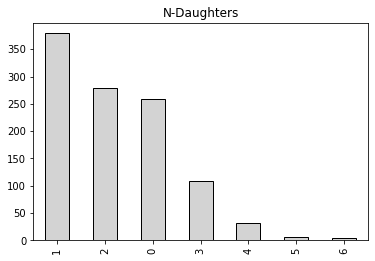

In [31]:
im_df.n_daughters.value_counts().plot(kind='bar', color='lightgrey', edgecolor='black', title='N-Daughters')

**Daughter types**

In [32]:
im_df.daughter_type.value_counts()

WQt0    126
xYq0     99
InfC     96
NmCl     67
WxY0     50
xQt0     44
ZYq0     35
WQtX     35
ZIm0     34
Ptcp     31
xYqX     21
AjCl     18
xQtX     15
XYqt     14
Ellp     11
WYq0     10
WXYq     10
ZQt0     10
ZYqX      9
Voct      9
WxQ0      9
Way0      8
CPen      7
MSyn      6
WXQt      5
Defc      5
ZQtX      4
WxYX      4
WYqX      3
xIm0      3
XQtl      2
WayX      2
XPos      2
WxQX      2
InfA      1
ZImX      1
XImp      1
WIm0      1
Name: daughter_type, dtype: int64

## Look for dependencies between mother and daughter clause types

In [35]:
moda_counts = pd.pivot_table(
    im_df,
    index='cl_type',
    columns='daughter_type',
    fill_value=0,
    aggfunc='size',
)

# sort by greatest sums
moda_counts = moda_counts.loc[im_df.cl_type.value_counts().index]

moda_counts.head()

daughter_type,AjCl,CPen,Defc,Ellp,InfA,InfC,MSyn,NmCl,Ptcp,Voct,...,ZImX,ZQt0,ZQtX,ZYq0,ZYqX,xIm0,xQt0,xQtX,xYq0,xYqX
xYq0,3,0,2,6,0,24,1,7,6,5,...,0,0,0,9,0,0,9,6,28,5
NmCl,4,3,2,0,0,10,0,17,5,0,...,1,2,0,4,4,2,6,2,10,2
xQt0,1,0,0,0,0,9,2,5,1,2,...,0,4,2,6,1,0,5,0,7,1
WxY0,0,0,1,0,0,9,1,4,4,0,...,0,0,0,4,0,0,4,0,13,2
xYqX,0,2,0,0,1,8,1,5,4,0,...,0,0,0,4,0,0,1,0,17,3


### Apply ΔP significance test

In [37]:
moda_dp = my_stats.apply_deltaP(moda_counts, 0, 1)

moda_dp.head()

daughter_type,AjCl,CPen,Defc,Ellp,InfA,InfC,MSyn,NmCl,Ptcp,Voct,...,ZImX,ZQt0,ZQtX,ZYq0,ZYqX,xIm0,xQt0,xQtX,xYq0,xYqX
xYq0,-0.009241,-0.011419,0.005258,0.022300,-0.001631,0.004372,-0.003080,-0.062346,-0.010326,0.018855,...,-0.001631,-0.016313,-0.006525,0.003271,-0.014682,-0.004894,-0.011411,0.015775,0.026308,-0.000720
NmCl,0.016364,0.021558,0.013896,-0.015714,-0.001429,-0.031948,-0.008571,0.083117,0.008312,-0.012857,...,0.009091,0.006753,-0.005714,-0.007922,0.029221,0.016753,0.000260,-0.000390,-0.036234,-0.008961
xQt0,-0.011853,-0.009669,-0.006906,-0.015193,-0.001381,-0.015515,0.017731,-0.027496,-0.029809,0.013587,...,-0.001381,0.038224,0.020493,0.029712,0.000578,-0.004144,0.004272,-0.020718,-0.045676,-0.015996
WxY0,-0.024658,-0.009589,0.007021,-0.015068,-0.001370,-0.006678,0.005651,-0.036301,0.013014,-0.012329,...,-0.001370,-0.013699,-0.005479,0.007534,-0.012329,-0.004110,-0.004795,-0.020548,0.044692,-0.001027
xYqX,-0.024490,0.019864,-0.006803,-0.014966,0.013333,-0.013061,0.006531,-0.017687,0.016599,-0.012245,...,-0.001361,-0.013605,-0.005442,0.011156,-0.012245,-0.004082,-0.045170,-0.020408,0.115102,0.015510


Browse results with respect to specific mother types.

In [50]:
moda_counts.loc['xYq0']['WQt0']

33

In [49]:
for mtype,value in im_df.cl_type.value_counts().items():
    
    dp_values = moda_dp.loc[mtype]
    
    print(mtype, value)
    display(dp_values[dp_values > 0].sort_values(ascending=False))
    print('-'*20)
    print()

xYq0 267


daughter_type
WxY0    0.106243
xYq0    0.026308
Ellp    0.022300
Voct    0.018855
WYq0    0.017224
WQt0    0.015800
xQtX    0.015775
Defc    0.005258
InfC    0.004372
XQtl    0.003445
XPos    0.003445
ZYq0    0.003271
WxYX    0.000182
Name: xYq0, dtype: float64

--------------------

NmCl 158


daughter_type
NmCl    0.083117
ZYqX    0.029221
ZIm0    0.025065
CPen    0.021558
xIm0    0.016753
AjCl    0.016364
Defc    0.013896
WQtX    0.013117
ZImX    0.009091
XImp    0.009091
Ptcp    0.008312
XQtl    0.007662
ZQt0    0.006753
WXQt    0.003377
XYqt    0.001039
xQt0    0.000260
Name: NmCl, dtype: float64

--------------------

xQt0 111


daughter_type
Way0    0.067005
WQt0    0.047122
ZQt0    0.038224
ZYq0    0.029712
ZQtX    0.020493
ZIm0    0.018084
MSyn    0.017731
WxQ0    0.013587
Voct    0.013587
XPos    0.010247
WayX    0.010247
WYqX    0.008865
xQt0    0.004272
WQtX    0.003694
ZYqX    0.000578
Name: xQt0, dtype: float64

--------------------

WxY0 96


daughter_type
WQt0    0.104795
xYq0    0.044692
WQtX    0.035274
Ptcp    0.013014
XYqt    0.008562
WxYX    0.008390
ZYq0    0.007534
Defc    0.007021
MSyn    0.005651
WxQ0    0.001541
WxY0    0.000856
Name: WxY0, dtype: float64

--------------------

xYqX 87


daughter_type
xYq0    0.115102
WXYq    0.059864
CPen    0.019864
Ptcp    0.016599
xYqX    0.015510
InfA    0.013333
WxQX    0.011973
ZYq0    0.011156
WQtX    0.011156
WYqX    0.010612
WxYX    0.009252
WXQt    0.007891
MSyn    0.006531
WQt0    0.004898
Name: xYqX, dtype: float64

--------------------

Ellp 78


daughter_type
xQt0    0.074351
WYq0    0.065909
Ptcp    0.064935
ZQt0    0.039610
Ellp    0.038312
AjCl    0.029221
xYqX    0.025325
WayX    0.023701
MSyn    0.018506
NmCl    0.018182
CPen    0.017208
WxY0    0.013961
ZIm0    0.008442
XYqt    0.008117
xQtX    0.006818
Name: Ellp, dtype: float64

--------------------

WxYX 41


daughter_type
WQtX    0.112338
InfC    0.085714
xQt0    0.048052
WQt0    0.046753
WYqX    0.022403
ZQt0    0.013312
Ellp    0.012013
XYqt    0.008117
AjCl    0.002922
Name: WxYX, dtype: float64

--------------------

AjCl 40


daughter_type
AjCl    0.183439
ZIm0    0.080510
ZYqX    0.071083
WxQ0    0.071083
NmCl    0.038471
ZYq0    0.037962
WxYX    0.036178
ZQt0    0.028535
XYqt    0.023439
Ptcp    0.001783
Name: AjCl, dtype: float64

--------------------

Ptcp 34


daughter_type
ZIm0    0.148148
InfC    0.145594
Ptcp    0.037037
ZYq0    0.031928
NmCl    0.029374
Voct    0.026820
xYq0    0.026820
Name: Ptcp, dtype: float64

--------------------

XYqt 26


daughter_type
WXYq    0.085099
xQtX    0.078762
CPen    0.040014
Ellp    0.034945
WxY0    0.034402
XYqt    0.031142
xYqX    0.022271
ZYq0    0.004527
WQtX    0.004527
Name: XYqt, dtype: float64

--------------------

xQtX 24


daughter_type
WxQ0    0.150309
NmCl    0.076984
WxQX    0.051367
ZQtX    0.048839
WXQt    0.047575
WxY0    0.044580
ZYqX    0.042518
XYqt    0.036197
xQtX    0.034932
WQtX    0.009648
WQt0    0.002395
Name: xQtX, dtype: float64

--------------------

WxQ0 23


daughter_type
xQt0    0.106062
InfC    0.094218
WQt0    0.056291
xIm0    0.050103
Way0    0.043782
WxQ0    0.042518
WYq0    0.041254
xQtX    0.034932
NmCl    0.023089
ZIm0    0.010912
Name: WxQ0, dtype: float64

--------------------

Defc 21


daughter_type
NmCl    0.208401
xYqX    0.120043
ZYq0    0.053413
xQt0    0.042006
xQtX    0.029875
AjCl    0.026073
InfC    0.024986
Ptcp    0.009596
Name: Defc, dtype: float64

--------------------

WXYq 15


daughter_type
WQt0    0.55125
Ptcp    0.06250
WQtX    0.05750
Name: WXYq, dtype: float64

--------------------

InfC 12


daughter_type
InfC    0.312756
NmCl    0.204768
Ptcp    0.105497
ZYq0    0.100516
Name: InfC, dtype: float64

--------------------

CPen 12


daughter_type
xYq0    0.298872
xYqX    0.142857
xQt0    0.114035
XYqt    0.067043
Ptcp    0.045739
NmCl    0.000627
Name: CPen, dtype: float64

--------------------

XQtl 11


daughter_type
xYq0    0.213483
WXQt    0.106117
Way0    0.102372
ZYqX    0.101124
Voct    0.101124
Ellp    0.098627
Name: XQtl, dtype: float64

--------------------

WxQX 8


daughter_type
InfC    0.132793
WXQt    0.120012
xQtX    0.107544
AjCl    0.103803
xQt0    0.071384
NmCl    0.042706
Name: WxQX, dtype: float64

--------------------

xIm0 2


daughter_type
WIm0    0.500000
ZQtX    0.496287
Name: xIm0, dtype: float64

--------------------

WXQt 1


daughter_type
WQt0    0.845488
Name: WXQt, dtype: float64

--------------------

xImX 1


daughter_type
ZIm0    0.959209
Name: xImX, dtype: float64

--------------------



In [57]:
im_df[im_df.cl_type == 'WXYq']

,ref,book,txt,cl_type,domain,n_daughters,daughter_type,daughet_text
43,Genesis 31:52,Genesis,וְאִם־אַ֠תָּה לֹא־תַעֲבֹ֨ר אֵלַ֜י אֶת־הַגַּ֥ל ...,WXYq,None,0,NaN,NaN
105,Exodus 21:23,Exodus,וְאִם־אָסֹ֖ון יִהְיֶ֑ה,WXYq,None,1,WQt0,וְנָתַתָּ֥ה נֶ֖פֶשׁ תַּ֥חַת נָֽפֶשׁ׃
150,Leviticus 4:13,Leviticus,וְאִ֨ם כָּל־עֲדַ֤ת יִשְׂרָאֵל֙ יִשְׁגּ֔וּ,WXYq,None,2,WQtX,וְנֶעְלַ֣ם דָּבָ֔ר מֵעֵינֵ֖י הַקָּהָ֑ל
151,Leviticus 4:27,Leviticus,וְאִם־נֶ֧פֶשׁ אַחַ֛ת תֶּחֱטָ֥א בִשְׁגָגָ֖ה מֵע...,WXYq,None,3,InfC,בַּ֠עֲשֹׂתָהּ אַחַ֨ת מִמִּצְוֹ֧ת יְהוָ֛ה
213,Leviticus 27:15,Leviticus,וְאִ֨ם־הַמַּקְדִּ֔ישׁ יִגְאַ֖ל אֶת־בֵּיתֹ֑ו,WXYq,None,1,WQt0,וְ֠יָסַף חֲמִישִׁ֧ית כֶּֽסֶף־עֶרְכְּךָ֛ עָלָ֖יו
252,Numbers 15:27,Numbers,וְאִם־נֶ֥פֶשׁ אַחַ֖ת תֶּחֱטָ֣א בִשְׁגָגָ֑ה,WXYq,None,3,WQt0,וְהִקְרִ֛יבָה עֵ֥ז בַּת־שְׁנָתָ֖הּ לְחַטָּֽאת׃
407,1_Samuel 17:9,1_Samuel,וְאִם־אֲנִ֤י אֽוּכַל־לֹו֙,WXYq,None,1,WQt0,וְהִכִּיתִ֔יו
444,2_Samuel 10:11,2_Samuel,וְאִם־בְּנֵ֤י עַמֹּון֙ יֶחֱזְק֣וּ מִמְּךָ֔,WXYq,None,1,WQt0,וְהָלַכְתִּ֖י
480,1_Kings 1:52,1_Kings,וְאִם־רָעָ֥ה תִמָּצֵא־בֹ֖ו,WXYq,None,1,WQt0,וָמֵֽת׃
582,Isaiah 49:24,Isaiah,וְאִם־שְׁבִ֥י צַדִּ֖יק יִמָּלֵֽט׃,WXYq,None,0,NaN,NaN


In [83]:
modal_qatal_counts = moda_counts[moda_counts.columns[moda_counts.columns.str.match('W.*Qt')]]

modal_qatal_counts = modal_qatal_counts.loc[modal_qatal_counts.sum(1) > 0]

modal_qatal_counts

daughter_type,WQt0,WQtX,WXQt
xYq0,33,6,0
NmCl,14,6,1
xQt0,17,4,0
WxY0,20,6,0
xYqX,12,4,1
Ellp,1,0,0
WxYX,8,6,0
Ptcp,1,0,0
XYqt,3,1,0
xQtX,3,1,1


In [84]:
modal_qatal_counts.sum().sum()

166

In [85]:
modal_qatal_dp = my_stats.apply_deltaP(modal_qatal_counts, 0, 1)

modal_qatal_dp

daughter_type,WQt0,WQtX,WXQt
xYq0,0.113870,-0.074500,-0.039370
NmCl,-0.105747,0.085714,0.020033
xQt0,0.057800,-0.023317,-0.034483
WxY0,0.012088,0.023626,-0.035714
xYqX,-0.059218,0.027240,0.031978
Ellp,0.242424,-0.212121,-0.030303
WxYX,-0.204887,0.237782,-0.032895
Ptcp,0.242424,-0.212121,-0.030303
XYqt,-0.009259,0.040123,-0.030864
xQtX,-0.163975,-0.011180,0.175155


In [86]:
for mtype,value in modal_qatal_counts.sum(1).items():
    
    dp_values = modal_qatal_dp.loc[mtype]
    
    print(mtype, value)
    display(dp_values[dp_values > 0].sort_values(ascending=False))
    print('-'*20)
    print()

xYq0 39


daughter_type
WQt0    0.11387
Name: xYq0, dtype: float64

--------------------

NmCl 21


daughter_type
WQtX    0.085714
WXQt    0.020033
Name: NmCl, dtype: float64

--------------------

xQt0 21


daughter_type
WQt0    0.0578
Name: xQt0, dtype: float64

--------------------

WxY0 26


daughter_type
WQtX    0.023626
WQt0    0.012088
Name: WxY0, dtype: float64

--------------------

xYqX 17


daughter_type
WXQt    0.031978
WQtX    0.027240
Name: xYqX, dtype: float64

--------------------

Ellp 1


daughter_type
WQt0    0.242424
Name: Ellp, dtype: float64

--------------------

WxYX 14


daughter_type
WQtX    0.237782
Name: WxYX, dtype: float64

--------------------

Ptcp 1


daughter_type
WQt0    0.242424
Name: Ptcp, dtype: float64

--------------------

XYqt 4


daughter_type
WQtX    0.040123
Name: XYqt, dtype: float64

--------------------

xQtX 5


daughter_type
WXQt    0.175155
Name: xQtX, dtype: float64

--------------------

WxQ0 4


daughter_type
WQt0    0.246914
Name: WxQ0, dtype: float64

--------------------

WXYq 8


daughter_type
WQt0    0.121835
Name: WXYq, dtype: float64

--------------------

XQtl 2


daughter_type
WXQt    0.47561
Name: XQtl, dtype: float64

--------------------

WxQX 2


daughter_type
WXQt    0.47561
Name: WxQX, dtype: float64

--------------------

WXQt 1


daughter_type
WQt0    0.242424
Name: WXQt, dtype: float64

--------------------



# Build Inspection Sheet

The categories of protasis and apodosis must be evaluated semantically.
Thus, this will need to be manually identified. To do this, we'll follow
a few steps.

1. Select an entire clause chain from an 'im' clause up to a Ve-qatal clause
with a given number of max intervening clauses
2. export a plain-text sheet where the 'im' clause is printed and its daughter
clauses printed with indentation below it

We can then place an asterix next to every valid apodosis case.

In [152]:
def climb_chain(cl_node):
    for daughter in E.mother.t(cl_node):
        yield daughter
        yield from climb_chain(daughter)
        


max_cl = 10
wqtl_re = re.compile('W.*Qt')

ignored = {
    'no_wqtl': [],
}

accepted = []
inspect_doc = ''

for cl, im in ims:
    
    daughters = E.mother.t(cl)
    daught_qtls = [d for d in daughters if wqtl_re.match(F.typ.v(d))]
    
    if not daught_qtls:
        ignored['no_wqtl'].append(cl)
        continue
        
    # build and add the case
    show_subtree = list(range(cl+1, daught_qtls[-1]+1))
    ref_tuple = T.sectionFromNode(cl)
    ref = '{} {}:{}'.format(*ref_tuple)
    heading = f'{len(accepted)+1}. {ref}'
    mo_typ = F.typ.v(cl)
    inspect_doc += heading + '\n'
    inspect_doc += f'{cl} {mo_typ} {T.text(cl)}\n'
    
    mother_indent = F.tab.v(cl)
    for kid in show_subtree:
        n_indent = F.tab.v(kid) - mother_indent
        indent = '  ' * n_indent
        k_type = F.typ.v(kid)
        inspect_doc += f'{indent} {kid} {k_type} {T.text(kid)}\n'
    
    inspect_doc += '\n'
    accepted.append(cl)
    
# report
print(f'{len(accepted)} clauses exported for inspection...')
print('cases ignored:')
for case, case_list in ignored.items():
    print(f'\t{case}: {len(case_list)}')

265 clauses exported for inspection...
cases ignored:
	no_wqtl: 803


In [153]:
Path('inspect_apodoses.txt').write_text(inspect_doc)

46875

In [ ]:

# for cl, im in ims:
    
#     daughters = E.mother.t(cl)
#     daught_qtls = [d for d in daughters if wqtl_re.match(d)]
    
#     subtree = list(climb_chain(cl))
        
#     sub_types = [F.typ.v(sc) for sc in subtree]
#     weqatal_types = [st for st in sub_types if wqtl_re.match(st)]
    
    
#     if not weqatal_types:
#         ignored['no_wqtl'].append(cl)
#         continue
    
#     first_weqatal = weqatal_types[0]
#     first_wqtl_index = sub_types.index(first_weqatal)
    
#     if first_wqtl_index > max_cl:
#         ignored['wqtl>max'].append(cl)
#         continue
        
#     # build and add the case
    
#     show_subtree = subtree[:max_cl+1]
#     ref_tuple = T.sectionFromNode(cl)
#     ref = '{} {}:{}'.format(*ref_tuple)
#     heading = f'{len(accepted)+1}. {ref}'
#     mo_typ = F.typ.v(cl)
#     inspect_doc += heading + '\n'
#     inspect_doc += f'{cl} {mo_typ} {T.text(cl)}\n'
    
#     mother_indent = F.tab.v(cl)
#     for kid in show_subtree:
#         n_indent = F.tab.v(kid) - mother_indent
#         indent = '  ' * n_indent
#         k_type = F.typ.v(kid)
#         inspect_doc += f'{indent} {kid} {k_type} {T.text(kid)}\n'
    
#     inspect_doc += '\n'
#     accepted.append(cl)
    